In [1]:
import warnings, torch, requests, matplotlib.pyplot as plt, networkx as nx
warnings.filterwarnings("ignore")

from transformers import BeitImageProcessor, BeitModel, BertTokenizer, BertModel
from torch_geometric.utils import to_networkx
from PIL import Image

from mmg_builder import build_multimodal_graph

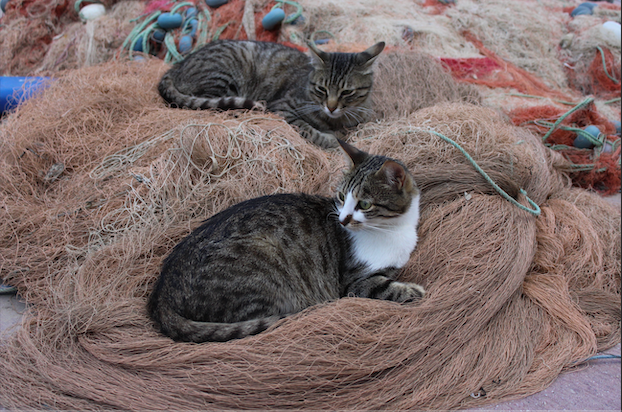

In [2]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")


model_name = "microsoft/beit-base-patch16-224"
beit_processor = BeitImageProcessor.from_pretrained(model_name)
beit = BeitModel.from_pretrained(model_name, use_safetensors=True)


# text = ["BERT is great for natural language processing!"]
text = ["BERT is great for natural language processing!", "Hi my name is Danik.", "Bob"]

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

image

In [3]:
text_inputs = bert_tokenizer(text, return_tensors="pt", padding=True)
print(f'{text_inputs=}')

# Forward pass (no gradient calculation needed for inference)
with torch.no_grad():
    outputs = bert(**text_inputs)

# Extract embeddings
text_embeds = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]

print(f'{text_embeds.shape=}')

text_inputs={'input_ids': tensor([[  101, 14324,  2003,  2307,  2005,  3019,  2653,  6364,   999,   102],
        [  101,  7632,  2026,  2171,  2003, 19522,  2243,  1012,   102,     0],
        [  101,  3960,   102,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}
text_embeds.shape=torch.Size([3, 10, 768])


In [4]:
img_inputs = beit_processor(images=[image]*3, return_tensors="pt")
print(f'{img_inputs["pixel_values"].shape=}')

with torch.no_grad():
    outputs = beit(**img_inputs, output_hidden_states=True)

# outputs.last_hidden_state → [batch_size, num_patches+1, hidden_dim]
# The first token is [CLS], the rest are patch embeddings
last_hidden = outputs.last_hidden_state

img_embeds = last_hidden[:, 1:, :]  # contextualized patch embeddings
print(f"Patches shape: {img_embeds.shape}")  # (1, num_patches, hidden_dim)


img_inputs["pixel_values"].shape=torch.Size([3, 3, 224, 224])
Patches shape: torch.Size([3, 196, 768])


In [5]:
res = build_multimodal_graph(
    text_embeds=text_embeds,
    image_embeds=img_embeds,
    attn_mask=text_inputs['attention_mask'],
    self_loops=False)

res

[Data(x=[212, 773], edge_index=[2, 1856], edge_attr=[1856, 6]),
 Data(x=[211, 773], edge_index=[2, 1852], edge_attr=[1852, 6]),
 Data(x=[205, 773], edge_index=[2, 1828], edge_attr=[1828, 6])]

#### plot function - donated by the generous Claude Sonnet 4.0 👑👑
Calculates node/edge colors from additional added features by build_multimodal_graph

In [6]:
def visualize_mmg_with_types(data, num_img, num_text, num_quadrants=4):
    """
    Visualize multimodal graph with node and edge colors matching the one-hot type features.
    
    Args:
        data: PyTorch Geometric Data object with node type features and edge type attributes
        num_img: Number of image nodes
        num_text: Number of text nodes  
        num_quadrants: Number of quadrant virtual nodes (default: 4)
    """
    
    N = int(num_img ** 0.5)
    G = to_networkx(data, to_undirected=True)
    
    # --- Same layout as original function ---
    pos = {}
    # Image grid
    for i in range(num_img):
        row, col = divmod(i, N)
        pos[i] = (col, -row)
    
    # Text nodes
    offset = num_img
    for i in range(num_text):
        pos[offset + i] = (N + 2, -i)
    
    # Quadrant virtuals
    q_nodes = list(range(num_img + num_text, num_img + num_text + num_quadrants))
    pos[q_nodes[0]] = (N/4, 1)        # top-left
    pos[q_nodes[1]] = (3*N/4, 1)      # top-right  
    pos[q_nodes[2]] = (N/4, -N-1)     # bottom-left
    pos[q_nodes[3]] = (3*N/4, -N-1)   # bottom-right
    
    # Text-global
    tg = num_img + num_text + num_quadrants
    pos[tg] = (N + 4, -num_text/2)
    
    # Fusion virtual
    fusion = tg + 1
    pos[fusion] = (N/2, 2)
    
    # --- Extract node types from one-hot features ---
    # Assuming node type features are the last 5 dimensions
    node_type_features = data.x[:, -5:]  # Last 5 dimensions are node types
    node_types = torch.argmax(node_type_features, dim=1).cpu().numpy()
    
    # Node type color mapping
    node_type_colors = {
        0: "skyblue",      # image patch
        1: "lightgreen",   # text tokens  
        2: "orange",       # quadrant virtuals
        3: "red",          # text-global
        4: "purple"        # fusion
    }
    
    node_colors = [node_type_colors.get(node_types[n], "gray") for n in G.nodes()]
    
    # --- Extract edge types from edge attributes ---
    edge_types = torch.argmax(data.edge_attr, dim=1).cpu().numpy()
    
    # Edge type color mapping (matching your EDGE_TYPES dict)
    edge_type_colors = {
        0: "blue",         # intra-text
        1: "cyan",         # intra-image  
        2: "orange",       # img-to-quadrant
        3: "red",          # quadrant-to-quadrant
        4: "green",        # text-to-global
        5: "purple"        # fusion-connection
    }
    
    # Create edge color list (NetworkX orders edges differently, so we need to map)
    edge_colors = []
    edge_list = list(G.edges())
    
    # Map NetworkX edges back to original edge indices
    for nx_edge in edge_list:
        # Find this edge in the original edge_index
        u, v = nx_edge
        # Since we converted to undirected, we need to check both directions
        found = False
        for i, (src, dst) in enumerate(data.edge_index.t().cpu().numpy()):
            if (src == u and dst == v) or (src == v and dst == u):
                edge_colors.append(edge_type_colors.get(edge_types[i], "gray"))
                found = True
                break
        if not found:
            edge_colors.append("gray")
    
    # --- Create the plot ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left plot: Node types
    nx.draw(G, pos, ax=ax1,
            node_color=node_colors,
            with_labels=False,
            node_size=200,
            edge_color="lightgray",
            alpha=0.7)
    ax1.set_title("Node Types from One-Hot Features", fontsize=14)
    
    # Add node type legend
    node_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor=color, markersize=10, label=label)
                           for label, color in [
                               ("Image Patch", "skyblue"),
                               ("Text Token", "lightgreen"), 
                               ("Quadrant Virtual", "orange"),
                               ("Text Global", "red"),
                               ("Fusion Virtual", "purple")
                           ]]
    ax1.legend(handles=node_legend_elements, loc='upper left')
    
    # Right plot: Edge types  
    nx.draw(G, pos, ax=ax2,
            node_color="lightgray",
            with_labels=False,
            node_size=150,
            edge_color=edge_colors,
            alpha=0.7,
            width=2)
    ax2.set_title("Edge Types from One-Hot Attributes", fontsize=14)
    
    # Add edge type legend
    edge_legend_elements = [plt.Line2D([0], [0], color=color, linewidth=3, label=label)
                           for label, color in [
                               ("Intra-Text", "blue"),
                               ("Intra-Image", "cyan"),
                               ("Image-to-Quadrant", "orange"), 
                               ("Quadrant-to-Quadrant", "red"),
                               ("Text-to-Global", "green"),
                               ("Fusion Connection", "purple")
                           ]]
    ax2.legend(handles=edge_legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # --- Print debug info ---
    print(f"Node type distribution:")
    unique, counts = torch.unique(torch.argmax(node_type_features, dim=1), return_counts=True)
    type_names = ["image", "text", "quadrant", "text-global", "fusion"]
    for t, c in zip(unique, counts):
        print(f"  {type_names[t]}: {c} nodes")
    
    print(f"\nEdge type distribution:")
    unique, counts = torch.unique(torch.argmax(data.edge_attr, dim=1), return_counts=True)
    edge_names = ["intra-text", "intra-image", "img-to-quadrant", 
                  "quadrant-to-quadrant", "text-to-global", "fusion-connection"]
    for t, c in zip(unique, counts):
        print(f"  {edge_names[t]}: {c} edges")

### plot

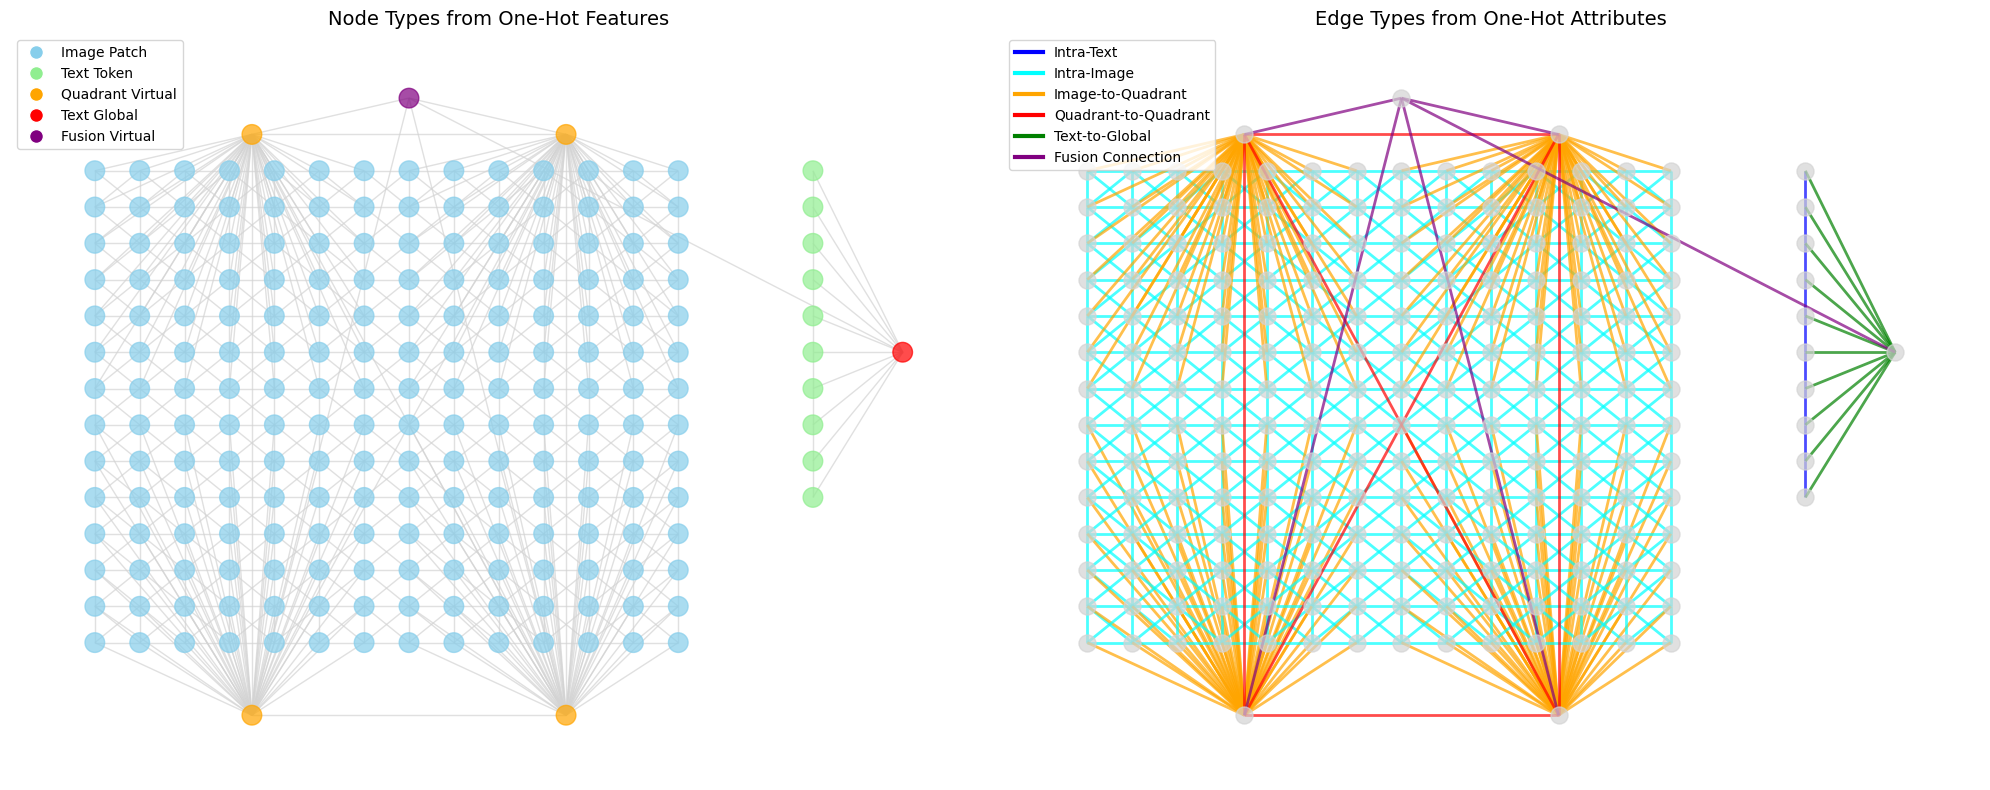

Node type distribution:
  image: 196 nodes
  text: 10 nodes
  quadrant: 4 nodes
  text-global: 1 nodes
  fusion: 1 nodes

Edge type distribution:
  intra-text: 18 edges
  intra-image: 1404 edges
  img-to-quadrant: 392 edges
  quadrant-to-quadrant: 12 edges
  text-to-global: 20 edges
  fusion-connection: 10 edges


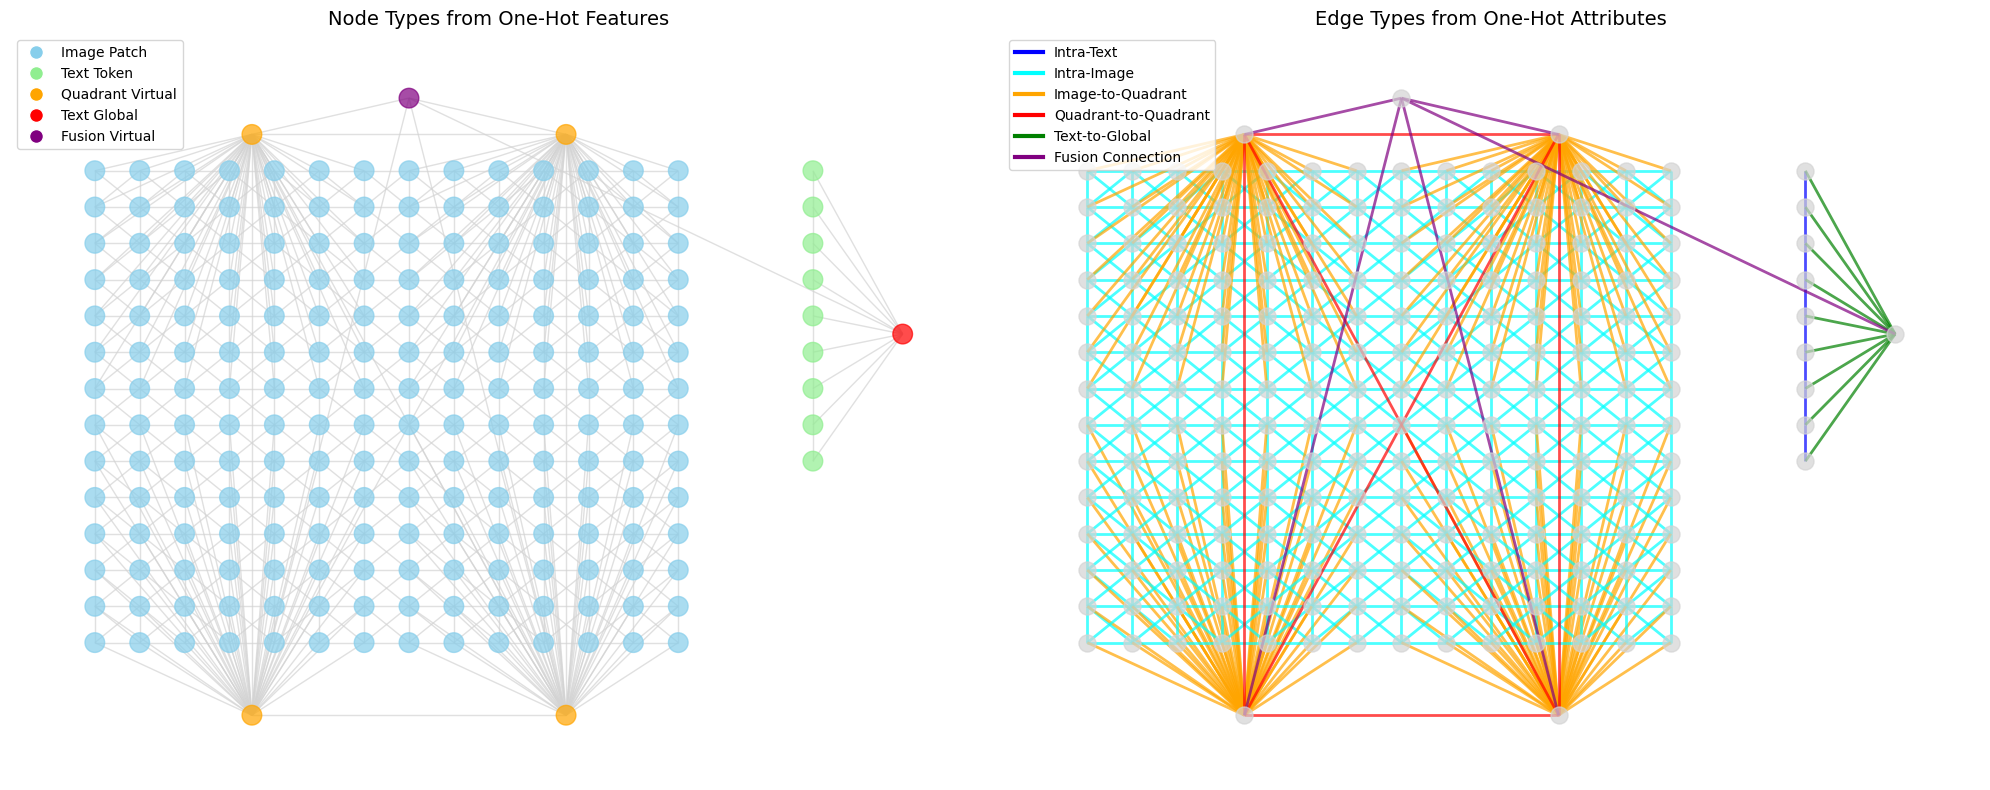

Node type distribution:
  image: 196 nodes
  text: 9 nodes
  quadrant: 4 nodes
  text-global: 1 nodes
  fusion: 1 nodes

Edge type distribution:
  intra-text: 16 edges
  intra-image: 1404 edges
  img-to-quadrant: 392 edges
  quadrant-to-quadrant: 12 edges
  text-to-global: 18 edges
  fusion-connection: 10 edges


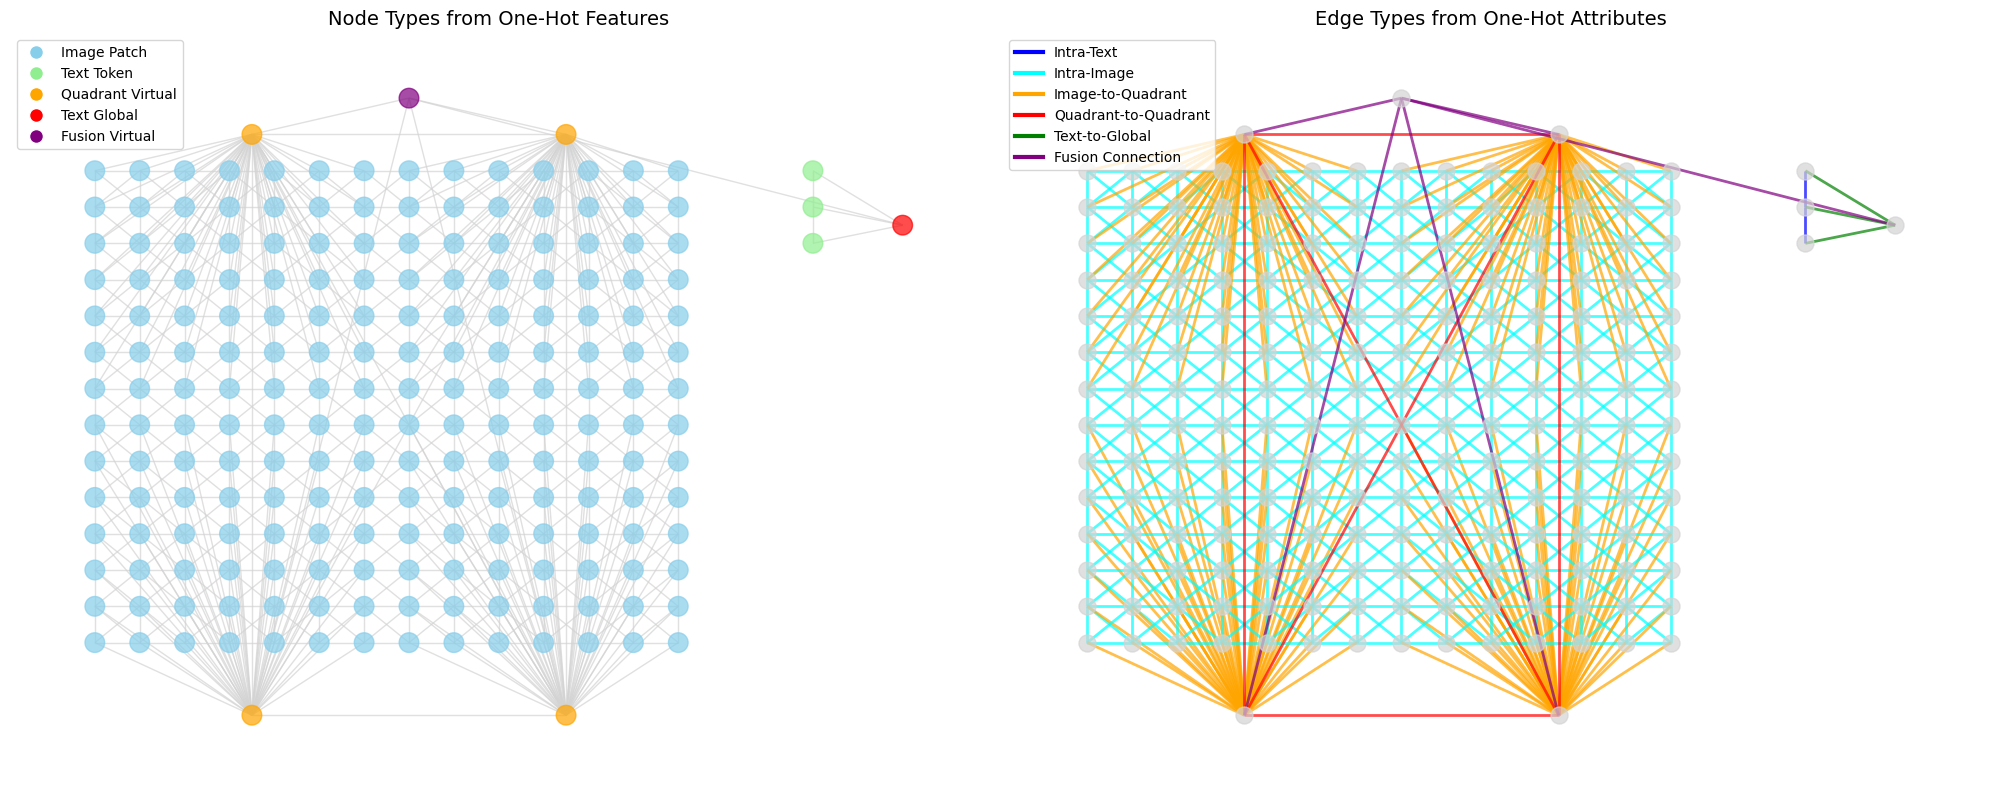

Node type distribution:
  image: 196 nodes
  text: 3 nodes
  quadrant: 4 nodes
  text-global: 1 nodes
  fusion: 1 nodes

Edge type distribution:
  intra-text: 4 edges
  intra-image: 1404 edges
  img-to-quadrant: 392 edges
  quadrant-to-quadrant: 12 edges
  text-to-global: 6 edges
  fusion-connection: 10 edges


In [7]:
for i in range(len(res)):
	visualize_mmg_with_types(res[i], num_img=img_embeds.shape[1], num_text=(text_inputs['attention_mask'][i] == 1).sum().item())